### Surrogate Modeling using GP with all dimensions

In [112]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES
from configuration.settings import current_density_parameters, physical_parameters, computing_parameters, operating_inputs
from model.AlphaPEM import AlphaPEM
import numpy as np
import pandas as pd

import numpy as np

def is_valid_curve(voltage_curve, tolerance=3, min_voltage=-5.0, max_voltage=1.23):
    voltage_curve = np.asarray(voltage_curve)

    # Condition 1: First value in range
    if not (0 <= voltage_curve[0] <= max_voltage):
        return False

    # Condition 2: First `tolerance` values in range
    if not np.all((0 <= voltage_curve[:tolerance]) & (voltage_curve[:tolerance] <= max_voltage)):
        return False

    # Condition 3: Monotonic decreasing
    if not np.all(np.diff(voltage_curve) <= 0):
        return False
    """
    # Condition 4: Final value must be greater than minimum voltage allowed
    if not voltage_curve[-1] > min_voltage:
        return False
    """
    return True

all_data = pd.read_csv('../data/raw/complete_samples_up_until_270525.csv')
lhs_data = pd.read_pickle('../data/raw/LHS_seed42_nsamples160_ndimensions16.pkl')
lhs_data2 = pd.read_pickle('../data/raw/LHS_seed42_nsamples100_ndimensions16_bounds25.pkl')

# Identify Ucell and ifc columns
ucell_cols = [col for col in all_data.columns if col.startswith('Ucell_')]
ifc_cols = [col for col in all_data.columns if col.startswith('ifc_')]

# Combine Ucell columns into lists per row
all_data['Ucell'] = all_data[ucell_cols].values.tolist()

columns = list(PARAMETER_RANGES.keys())
columns.append('Ucell')

df_combined = pd.concat([all_data[columns], lhs_data[columns], lhs_data2[columns]], axis=0, ignore_index=True)

df_combined['valid'] = df_combined['Ucell'].apply(is_valid_curve)
lhs_data['valid'] = df_combined['Ucell'].apply(is_valid_curve)
lhs_data2['valid'] = df_combined['Ucell'].apply(is_valid_curve)
all_data['valid'] = df_combined['Ucell'].apply(is_valid_curve)

data = df_combined

Plot true curves

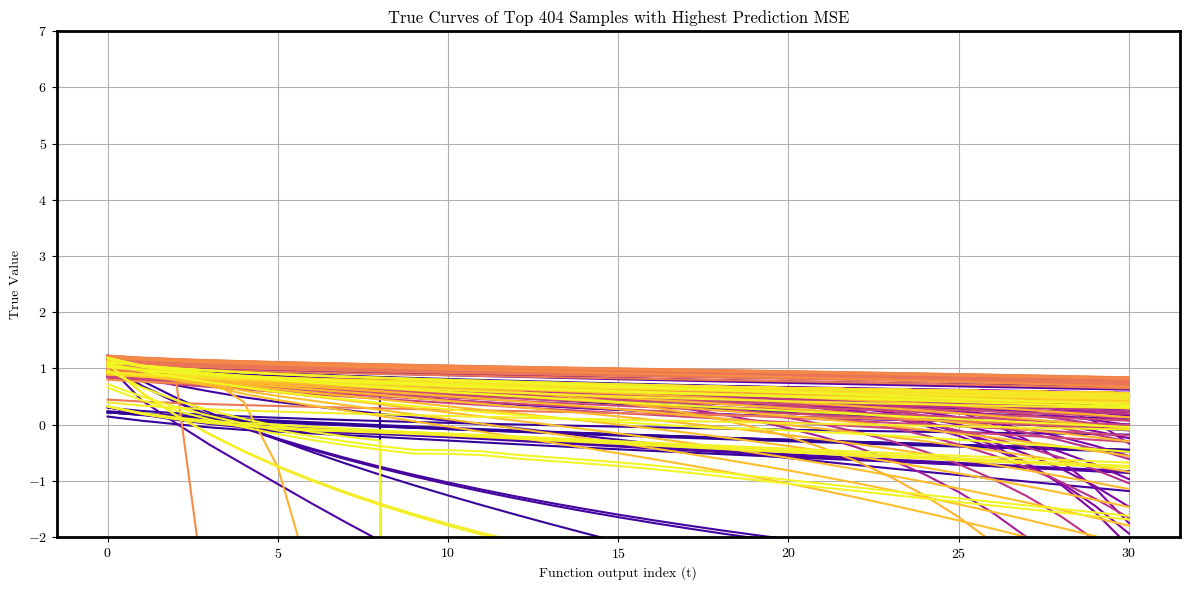

In [113]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_true_curves(Y_true, Y_pred, top_k=10):
    """
    Plot only the true curves of the top_k samples with highest MSE.
    
    Args:
        Y_true (np.array): True function outputs, shape (n_samples_total, T)
        Y_pred (np.array): Predicted function outputs, shape (n_samples_total, T)
        top_k (int): Number of worst-predicted samples to plot
    """
    # Compute per-sample MSE
    mse_per_sample = np.mean(np.abs(Y_true - Y_pred), axis=1)
    
    # Indices of top_k samples with highest MSE
    top_indices = np.argsort(mse_per_sample)[-top_k:]
    
    # Plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.plasma(np.linspace(0, 1, top_k))
    
    for idx, color in zip(top_indices, colors):
        t = np.arange(Y_true.shape[1])
        plt.plot(t, Y_true[idx], label=f'Sample {idx} (MSE={mse_per_sample[idx]:.3f})', color=color)
    
    plt.xlabel('Function output index (t)')
    plt.ylabel('True Value')
    plt.title(f'True Curves of Top {top_k} Samples with Highest Prediction MSE')
    plt.grid(True)
    plt.ylim(-2, 7)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example call
all_Y = np.array(data['Ucell'].tolist())
mask_valid = np.array([is_valid_curve(row) for row in all_Y])
all_Y = all_Y[mask_valid]

# Split data
plot_top_true_curves(all_Y, all_Y, top_k=len(all_Y))


Strech curves to avoid very negative values

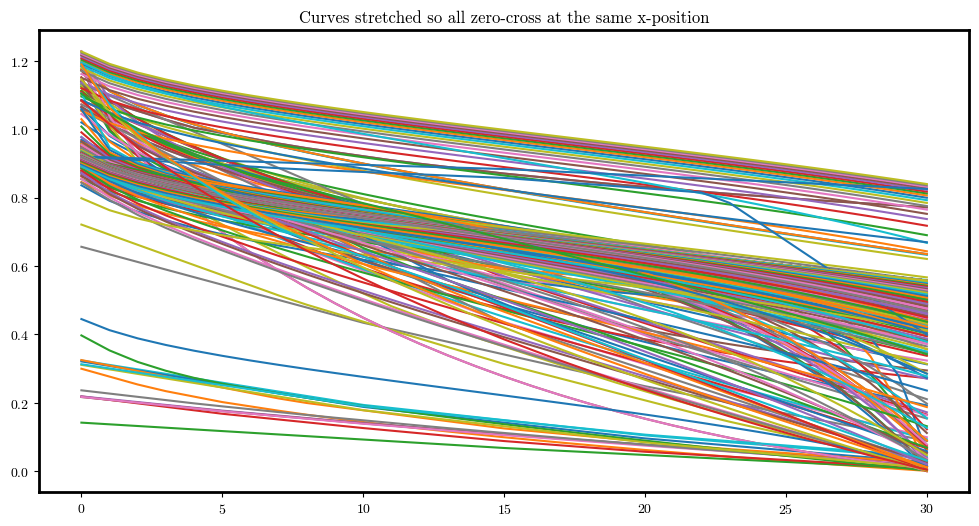

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def find_last_zero_crossing(y):
    # Find last zero crossing index (or fractional index by linear interpolation)
    signs = np.sign(y)
    zero_crossings = np.where(np.diff(signs))[0]
    if len(zero_crossings) == 0:
        return len(y) - 1  # no zero crossing, return last index
    else:
        return zero_crossings[-1]

def stretch_curves_to_align_zero(all_Y, common_zero_pos=None):
    n_curves, T = all_Y.shape
    zero_crossings = np.array([find_last_zero_crossing(curve) for curve in all_Y])
    
    if common_zero_pos is None:
        common_zero_pos = zero_crossings.max()  # align all to the latest zero-crossing
    
    stretched_curves = []
    new_x = np.arange(T)
    
    for curve, zero_pos in zip(all_Y, zero_crossings):
        # original x-axis for curve segment up to zero crossing
        orig_x = np.linspace(0, zero_pos, zero_pos + 1)
        orig_y = curve[:zero_pos + 1]
        
        # new stretched x-axis for that segment
        stretched_x = np.linspace(0, common_zero_pos, zero_pos + 1)
        
        # interpolation function for stretching
        f = interp1d(stretched_x, orig_y, bounds_error=False, fill_value="extrapolate")
        stretched_curve_part = f(new_x[:common_zero_pos + 1])
        
        # tail after zero crossing set to zero
        tail = np.zeros(T - common_zero_pos - 1)
        stretched_curve = np.concatenate([stretched_curve_part, tail])
        stretched_curves.append(stretched_curve)
    
    return np.array(stretched_curves), zero_crossings, common_zero_pos

from scipy.interpolate import interp1d
import numpy as np

def inverse_stretch_curves(stretched_Y, zero_crossings, common_zero_pos):
    """
    Map predictions from stretched zero-aligned space back to original time space per curve.

    Parameters:
        stretched_Y: np.array shape (n_curves, T), predicted curves in stretched domain
        zero_crossings: array of length n_curves, original zero-crossing positions per curve
        common_zero_pos: int, the common zero-crossing position used for stretching
    
    Returns:
        orig_Y: np.array shape (n_curves, T), curves mapped back to original time domain
    """
    n_curves, T = stretched_Y.shape
    orig_Y = np.zeros_like(stretched_Y)

    new_x = np.arange(T)  # full grid for output
    
    for i in range(n_curves):
        zero_pos = zero_crossings[i]
        # Define stretched domain x
        stretched_x = np.linspace(0, common_zero_pos, common_zero_pos + 1)
        # Original domain x for curve i
        orig_x = np.linspace(0, zero_pos, zero_pos + 1)
        
        # Interpolator from stretched domain to original domain
        f = interp1d(stretched_x, stretched_Y[i, :common_zero_pos + 1], bounds_error=False, fill_value=0)
        
        # Map full original x to stretched domain, then get values
        # Because we want Y(orig_x), we do inverse mapping by interpolation:
        # But since f maps from stretched->original, we need to invert the axis, so interpolate:
        # Actually, since we want values on original_x, we can do:
        # Evaluate at points mapped from original to stretched, i.e. we want Y(orig_x):
        # So we want inverse of stretching, which is: orig_x = (zero_pos/common_zero_pos) * stretched_x
        # Hence for each orig_x, find corresponding stretched_x and sample stretched_Y.

        # Compute stretched_x points corresponding to original x grid
        # So for points in original domain new_x, compute corresponding stretched_x:
        stretched_x_points = new_x * (common_zero_pos / zero_pos) if zero_pos != 0 else np.zeros_like(new_x)
        
        # Clip to domain of stretched_x to avoid extrapolation beyond stretch domain
        stretched_x_points = np.clip(stretched_x_points, 0, common_zero_pos)
        
        # Interpolate from stretched_Y at those points
        interp_func = interp1d(np.arange(T), stretched_Y[i], bounds_error=False, fill_value=0)
        orig_Y[i] = interp_func(stretched_x_points)
        
        # After zero crossing, set tail to zero (or keep original behavior)
        orig_Y[i, zero_pos+1:] = 0

    return orig_Y


# Example usage:
stretched_Y, zero_crossings, common_zero_pos = stretch_curves_to_align_zero(all_Y)

# Plot
plt.figure(figsize=(12, 6))
for curve in stretched_Y:
    plt.plot(curve)
plt.title("Curves stretched so all zero-cross at the same x-position")
plt.show()


Train and test GP and vizualize results

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel
from sklearn.multioutput import RegressorChain

# X: input parameters (n_samples × n_features)
# Y: output functions (n_samples × t_points)
X = np.array(data[PARAMETER_RANGES.keys()])
Y = np.array(data['Ucell'].tolist())

# Filter invalid outputs
#mask_valid = np.all((Y > 0) & (Y < 1.5), axis=1)
X = X[mask_valid]
Y = Y[mask_valid]
Y = stretched_Y

def train_GP(X, Y, test_size=0.2, random_state=42):
    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    # Scale input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Optional: apply PCA on inputs (not outputs)
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)


    # Fit multi-output GP
    kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
    gp = GaussianProcessRegressor(n_restarts_optimizer=10, kernel=kernel, normalize_y=True)
    multi_gp = MultiOutputRegressor(gp)
    multi_gp.fit(X_train_pca, Y_train)

    # Predict means and std deviations
    Y_pred = []
    Y_std = []

    for estimator in multi_gp.estimators_:
        mu, std = estimator.predict(X_test_pca, return_std=True)
        Y_pred.append(mu)
        Y_std.append(std)

    # Convert to (n_samples, n_outputs)
    Y_pred = np.array(Y_pred).T
    Y_std = np.array(Y_std).T

    # Evaluation
    mse_per_point = np.mean((Y_pred - Y_test) ** 2, axis=0)
    avg_mse = np.mean(mse_per_point)
    print("Average MSE across all time points:", avg_mse)

    return multi_gp, Y_test, Y_pred, Y_std, X_test_pca

multi_gp, Y_test_stretched, Y_pred_stretched, Y_std, X_test_pca = train_GP(X, Y)

# Map predicted and test outputs back to original domain
Y_test_original = inverse_stretch_curves(Y_test_stretched, zero_crossings, common_zero_pos)
Y_pred_original = inverse_stretch_curves(Y_pred_stretched, zero_crossings, common_zero_pos)
Y_std_original = inverse_stretch_curves(Y_std, zero_crossings, common_zero_pos)

c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Average MSE across all time points: 0.006368108495456407


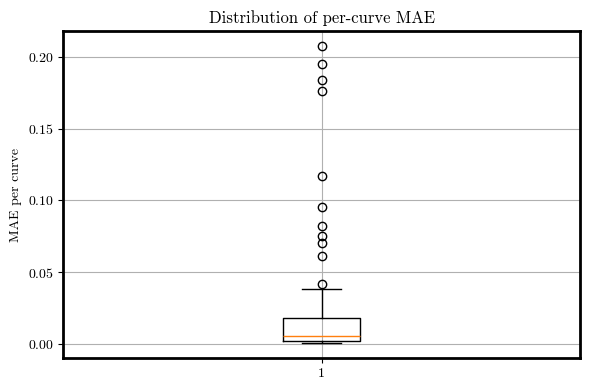

In [159]:
import numpy as np
Y_test = Y_test_original
Y_pred = Y_pred_original

# Shape: (n_samples, n_timepoints)
errors = Y_pred - Y_test
mae_per_curve = np.mean(np.abs(errors), axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(mae_per_curve, vert=True)
plt.ylabel('MAE per curve')
plt.title('Distribution of per-curve MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


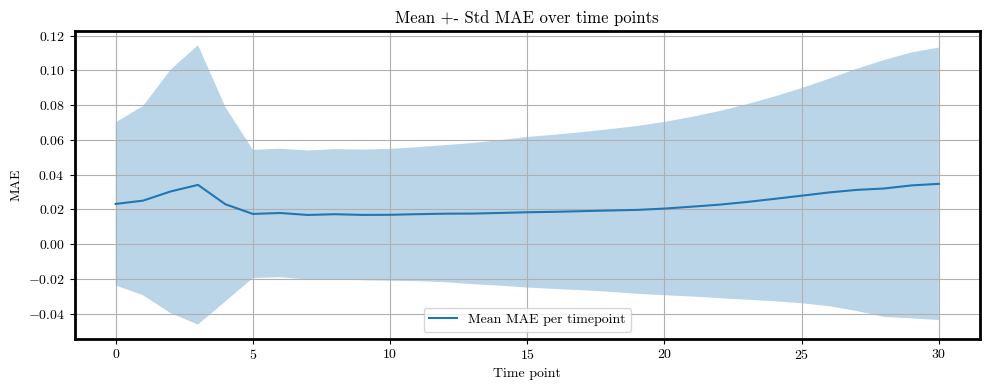

In [144]:
mae_per_t = np.mean(np.abs(errors), axis=0)
std_per_t = np.std(np.abs(errors), axis=0)

plt.figure(figsize=(10, 4))
plt.plot(mae_per_t, label='Mean MAE per timepoint')
plt.fill_between(range(len(mae_per_t)), mae_per_t - std_per_t, mae_per_t + std_per_t, alpha=0.3)
plt.xlabel('Time point')
plt.ylabel('MAE')
plt.title('Mean +- Std MAE over time points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


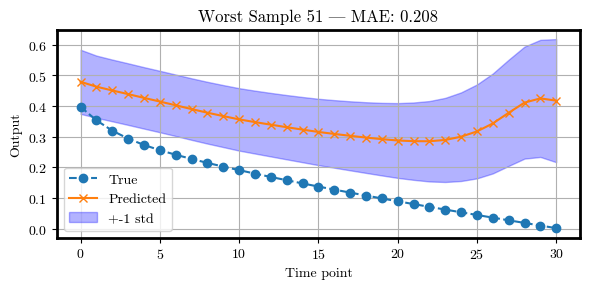

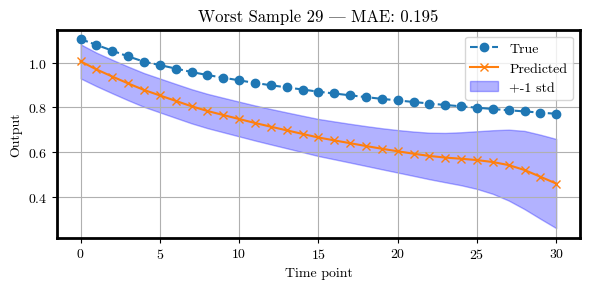

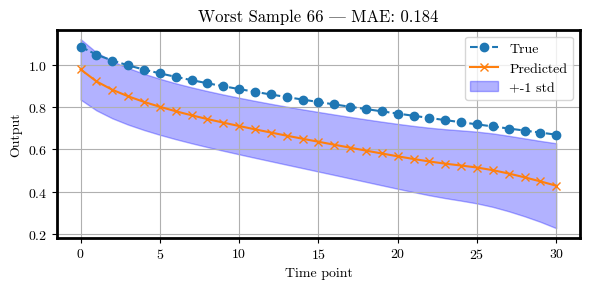

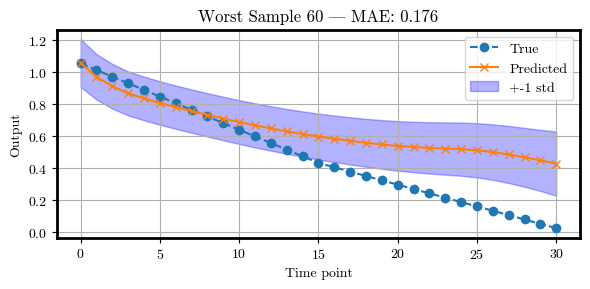

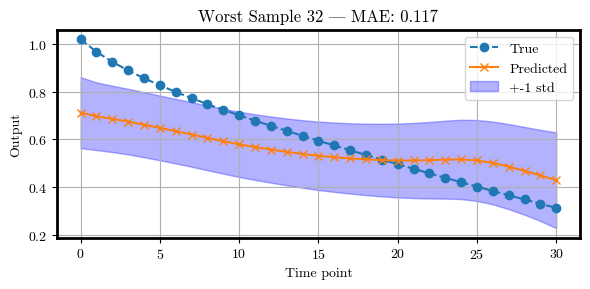

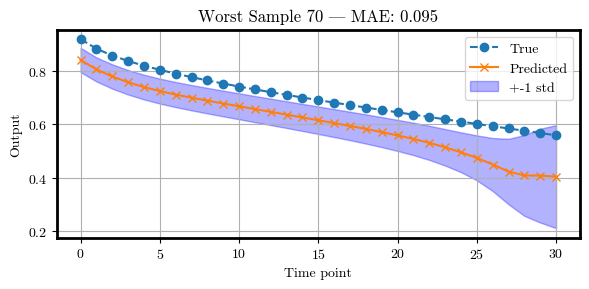

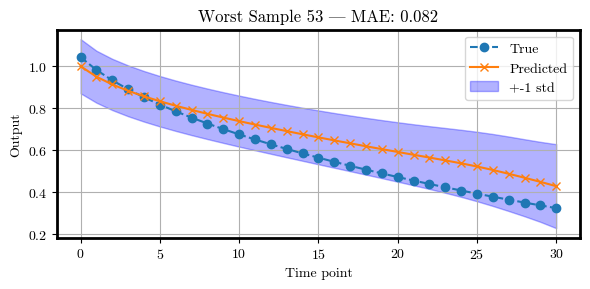

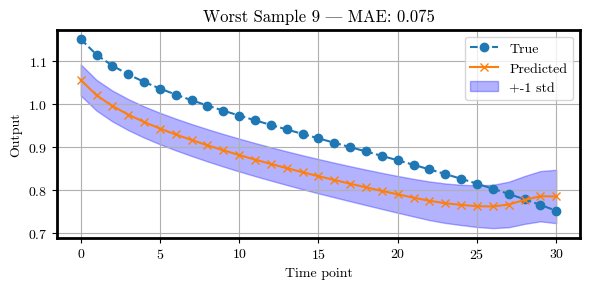

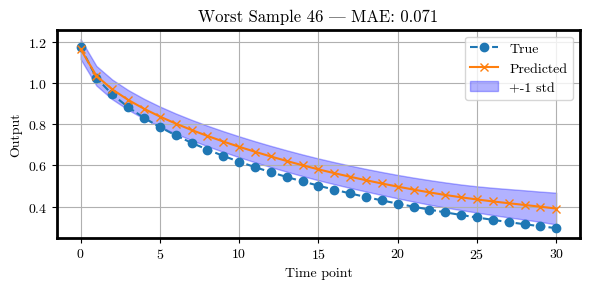

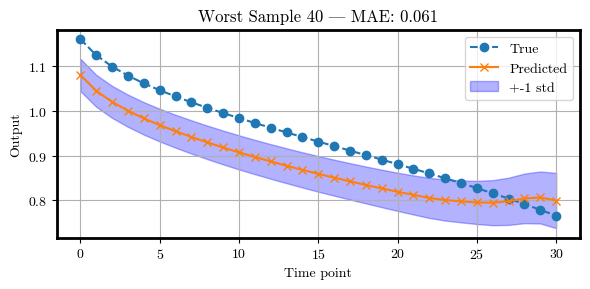

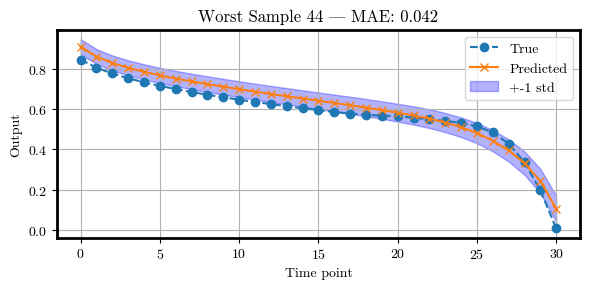

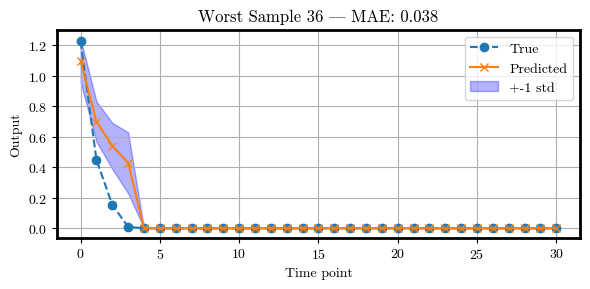

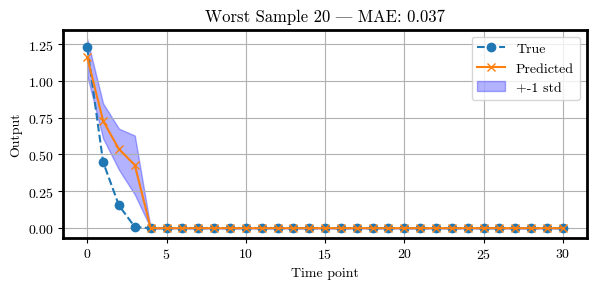

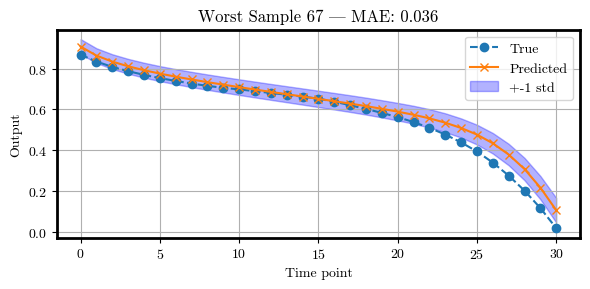

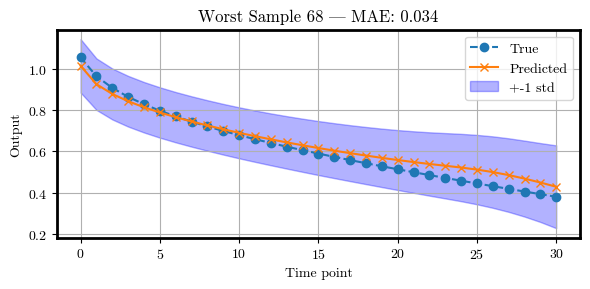

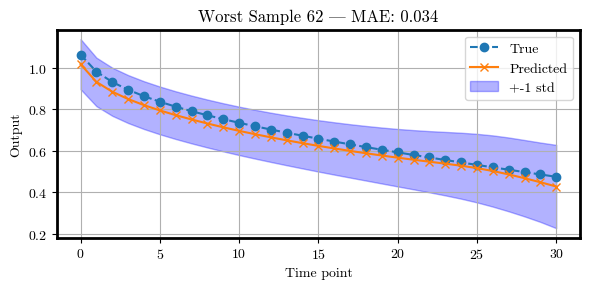

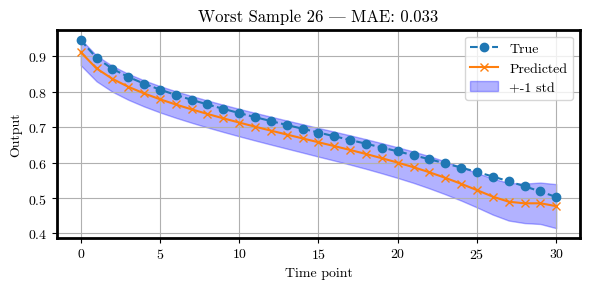

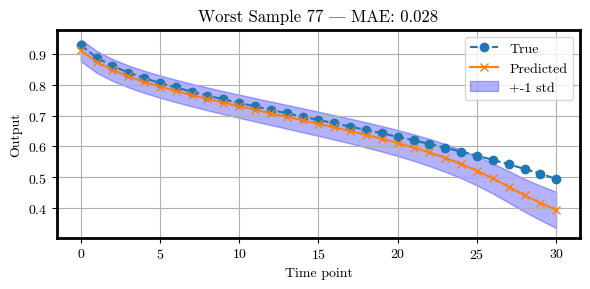

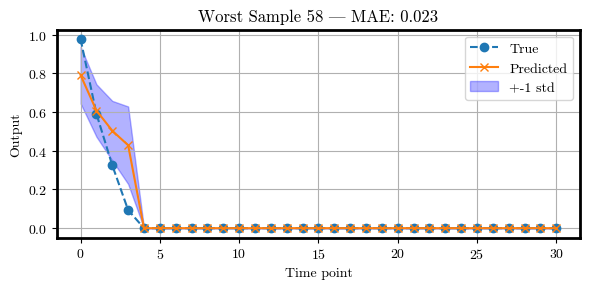

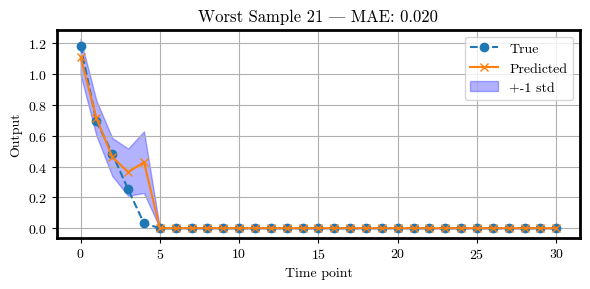

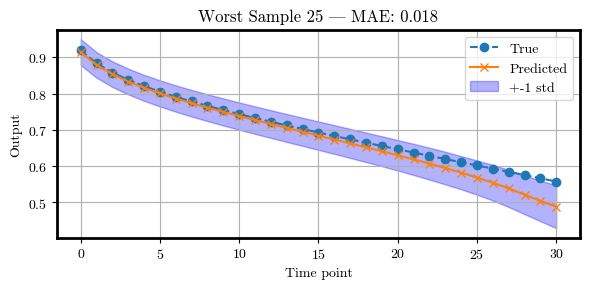

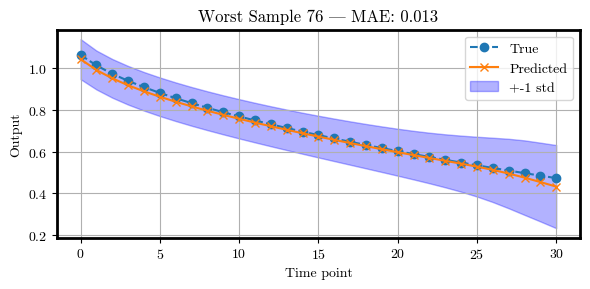

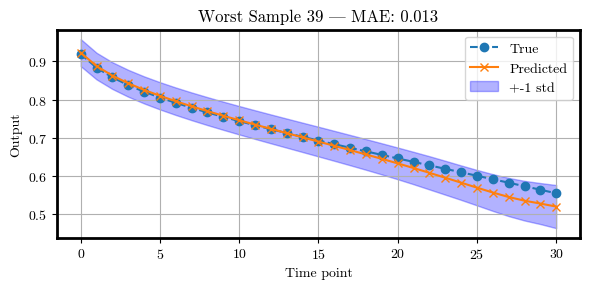

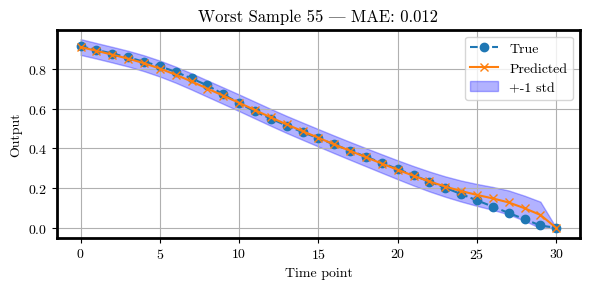

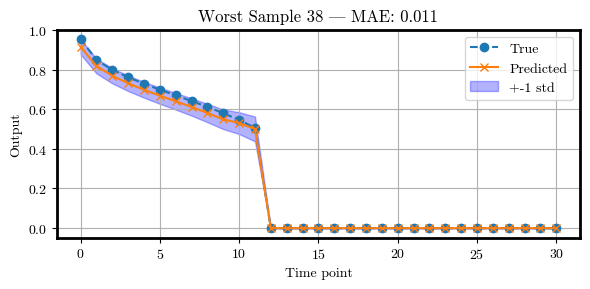

In [162]:
Y_std = Y_std_original

# Convert to (n_samples, n_outputs)
Y_pred = Y_pred_original
Y_test = Y_test_original

# MAE per test curve (you must have computed this before)
mae_per_curve = np.mean(np.abs(Y_pred - Y_test), axis=1)

# Indices of the worst curves (highest MAE)
worst_indices = np.argsort(mae_per_curve)[-25:]  # last 5 (i.e. highest errors)

# Plot with uncertainty
for idx in worst_indices[::-1]:
    plt.figure(figsize=(6, 3))
    time = np.arange(Y_test.shape[1])
    plt.plot(time, Y_test[idx], label='True', linestyle='--', marker='o')
    plt.plot(time, Y_pred[idx], label='Predicted', marker='x')
    plt.fill_between(time,
                     Y_pred[idx] - Y_std[idx],
                     Y_pred[idx] + Y_std[idx],
                     alpha=0.3, color='blue', label='+-1 std')
    plt.title(f'Worst Sample {idx} | MAE: {mae_per_curve[idx]:.3f}')
    plt.xlabel('Time point')
    plt.ylabel('Output')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from pyDOE import lhs
import numpy as np

# Define parameter order used in training (including Pc_des!)
FEATURE_ORDER = [
    'Tfc', 'Pa_des', 'Pc_des', 'Sc', 'Phi_c_des',
    'epsilon_gdl', 'tau', 'epsilon_mc', 'epsilon_c',
    'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c',
    'a_slim', 'b_slim', 'a_switch'
]

# Separate continuous and categorical keys
continuous_keys = [k for k in PARAMETER_RANGES if isinstance(PARAMETER_RANGES[k], tuple)]
categorical_keys = [k for k in PARAMETER_RANGES if isinstance(PARAMETER_RANGES[k], list)]

n_candidates = 1000
n_cont = len(continuous_keys)

# Latin Hypercube Sampling for continuous parameters
lhs_samples = lhs(n_cont, samples=n_candidates)

# Rescale to actual bounds
X_continuous = np.zeros_like(lhs_samples)
for i, key in enumerate(continuous_keys):
    low, high = PARAMETER_RANGES[key]
    X_continuous[:, i] = lhs_samples[:, i] * (high - low) + low

# Handle categorical variables
X_categorical = {}
rng = np.random.default_rng(seed=42)  # For reproducibility
for key in categorical_keys:
    X_categorical[key] = rng.choice(PARAMETER_RANGES[key], size=n_candidates)

# Combine all into a dictionary
X_candidates = {}
for i, key in enumerate(continuous_keys):
    X_candidates[key] = X_continuous[:, i]
for key in categorical_keys:
    X_candidates[key] = X_categorical[key]

# Compute Pc_des = Pa_des - 2000
X_candidates['Pc_des'] = X_candidates['Pa_des'] - 2000

# Assemble the input array in the exact order used during scaler/PCA fitting
X_array = np.column_stack([X_candidates[key] for key in FEATURE_ORDER])

# 2. Preprocess (scale + PCA)
X_array_scaled = scaler.transform(X_array)
X_array_pca = pca.transform(X_array_scaled)

# 3. Predict with GP and get uncertainty
mu_list, std_list = [], []
for estimator in multi_gp.estimators_:
    mu, std = estimator.predict(X_array_pca, return_std=True)
    mu_list.append(mu)
    std_list.append(std)

# Stack std deviations and compute mean uncertainty
Y_std = np.stack(std_list, axis=1)  # shape (n_samples, n_outputs)
uncertainty = np.mean(Y_std, axis=1)

# 4. Select top-k most uncertain samples
k = 10
idx_topk = np.argsort(uncertainty)[-k:]
X_selected = X_array[idx_topk]

df_selected = pd.DataFrame(X_selected, columns=PARAMETER_RANGES.keys())
df_selected

Cluster curves

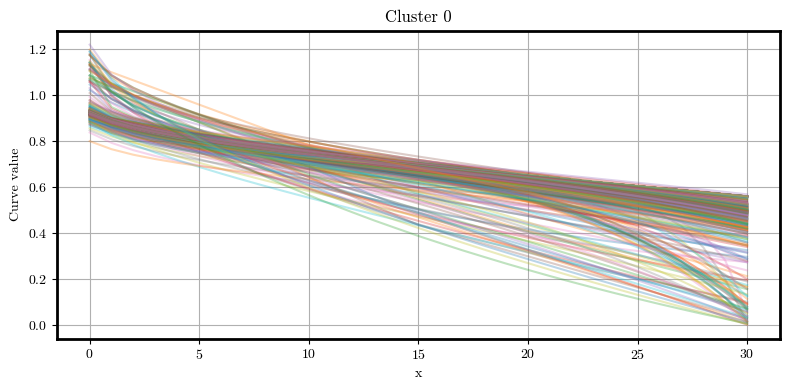

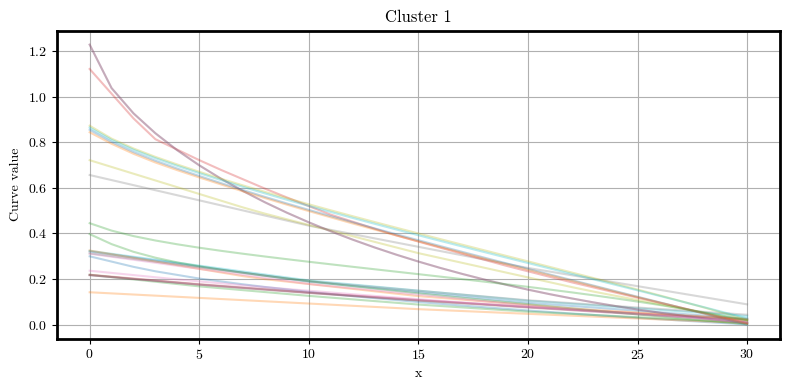

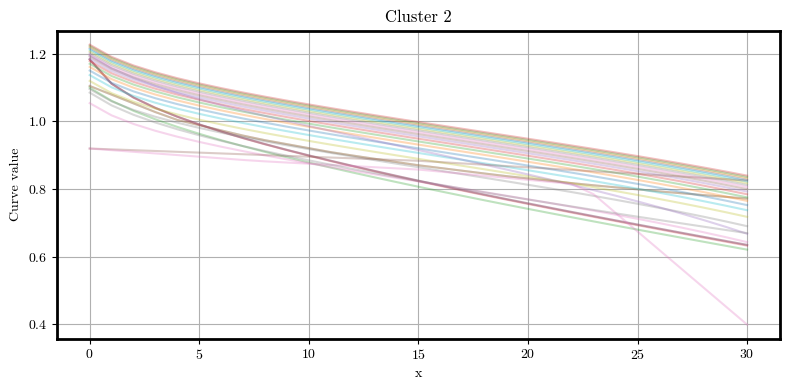

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# === Step 1: Normalize the curves ===
# Input: all_Y of shape (160, 30) — 160 curves, each with 30 y-values
scaler = StandardScaler()
curves_normalized = scaler.fit_transform(stretched_Y)  # normalize each curve (row-wise)

# === Step 2: Reduce dimensionality with PCA ===
# This helps with clustering by capturing the main variance directions
pca = PCA(n_components=10)
curve_features = pca.fit_transform(curves_normalized)

# === Step 3: Cluster the curves ===
k = 3  # You can set this to any number of clusters you want
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(curve_features)

# === Step 4: Visualize the clusters ===
x = list(range(0, 31))  # x-values for plotting (assumed shared across all curves)

for cluster_id in range(k):
    plt.figure(figsize=(8, 4))
    plt.title(f"Cluster {cluster_id}")
    
    # Plot all curves assigned to this cluster
    for i in range(len(all_Y)):
        if labels[i] == cluster_id:
            plt.plot(x, stretched_Y[i], alpha=0.3)
    
    plt.xlabel("x")
    plt.ylabel("Curve value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Fit a GP per cluster

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# === Step 1: Normalize the curves ===
# Input: all_Y of shape (160, 30) — 160 curves, each with 30 y-values
scaler = StandardScaler()
curves_normalized = scaler.fit_transform(stretched_Y)  # normalize each curve (row-wise)

# === Step 2: Reduce dimensionality with PCA ===
# This helps with clustering by capturing the main variance directions
pca = PCA(n_components=10)
curve_features = pca.fit_transform(curves_normalized)

# === Step 3: Cluster the curves ===
k = 3  # You can set this to any number of clusters you want
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(curve_features)

X = np.array(data[PARAMETER_RANGES.keys()])
Y = np.array(data['Ucell'].tolist())

# Filter invalid outputs
#mask_valid = np.all((Y > 0) & (Y < 1.5), axis=1)
X = X[mask_valid]
Y = Y[mask_valid]

stretched_Y, zero_crossings, common_zero_pos = stretch_curves_to_align_zero(all_Y)


In [ ]:
from sklearn.ensemble import IsolationForest
def remove_outliers_isolation_forest(X, Y, contamination=0.1, random_state=42):
    """
    Uses Isolation Forest to remove multivariate outliers based on both X and Y.
    Returns filtered X and Y.
    """
    combined = np.hstack([X, Y])
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    labels = iso.fit_predict(combined)  # -1 for outliers, 1 for inliers
    mask = labels == 1
    return X[mask], Y[mask]


In [ ]:
cluster_results = []

for cluster in range(k):
    cluster_X = X[labels == cluster]
    cluster_Y = stretched_Y[labels == cluster]

    # 🔹 Remove outliers using Isolation Forest
    cluster_X_clean, cluster_Y_clean = remove_outliers_isolation_forest(cluster_X, cluster_Y, contamination=0.1)

    # 🔹 Train GP on cleaned data
    multi_gp, Y_test_stretched, Y_pred_stretched, Y_std_stretched, X_test_pca = train_GP(cluster_X_clean, cluster_Y_clean)

    # 🔹 Unstretch outputs
    Y_test = inverse_stretch_curves(Y_test_stretched, zero_crossings, common_zero_pos)
    Y_pred = inverse_stretch_curves(Y_pred_stretched, zero_crossings, common_zero_pos)
    Y_std = inverse_stretch_curves(Y_std_stretched, zero_crossings, common_zero_pos)

    # 🔹 Compute MAE
    mae_per_curve = np.mean(np.abs(Y_pred - Y_test), axis=1)

    # 🔹 Store cluster results
    cluster_results.append({
        "cluster_id": cluster,
        "multi_gp": multi_gp,
        "X_test_pca": X_test_pca,
        "Y_test": Y_test,
        "Y_pred": Y_pred,
        "Y_std": Y_std,
        "mae_per_curve": mae_per_curve
    })


Average MSE across all time points: 0.0020050151199981514


c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Average MSE across all time points: 0.0018546437581056635


c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of p

Average MSE across all time points: 0.0028427937769164415


c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of p

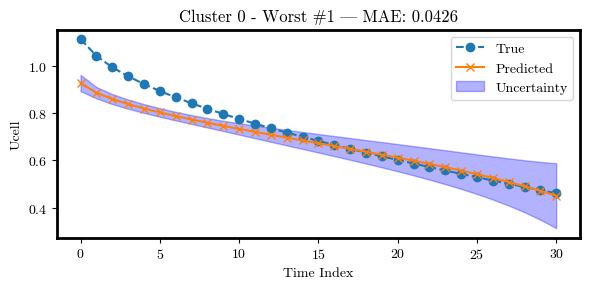

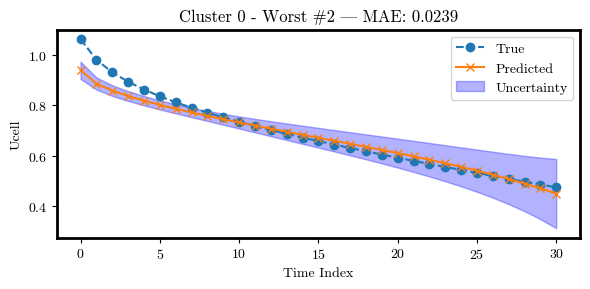

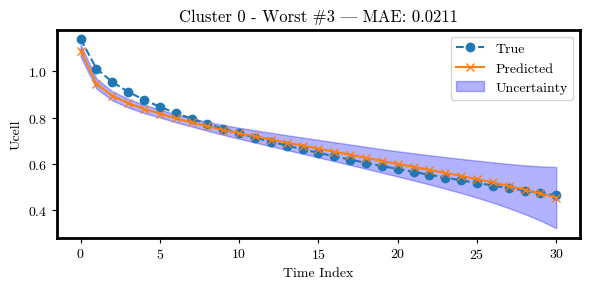

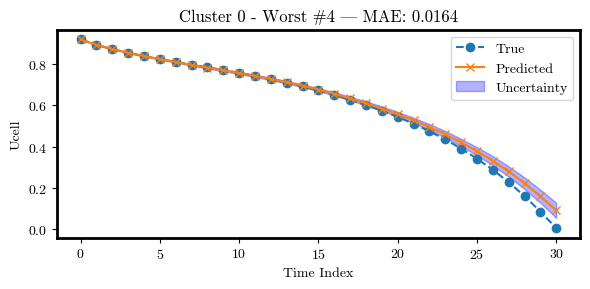

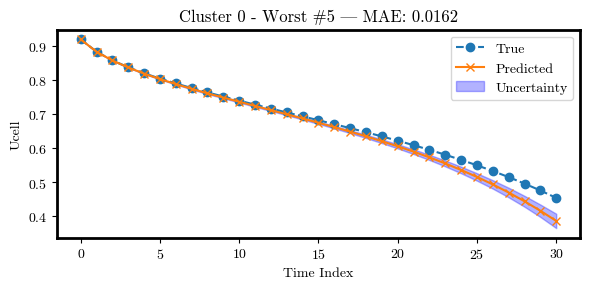

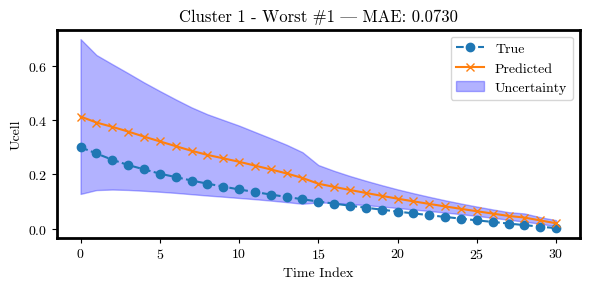

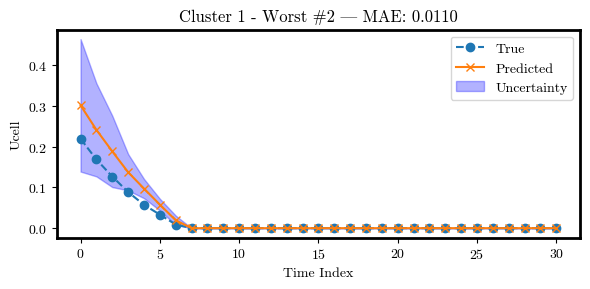

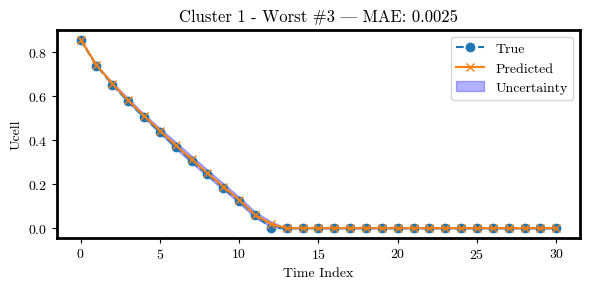

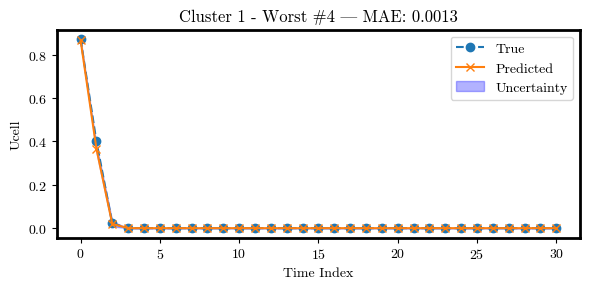

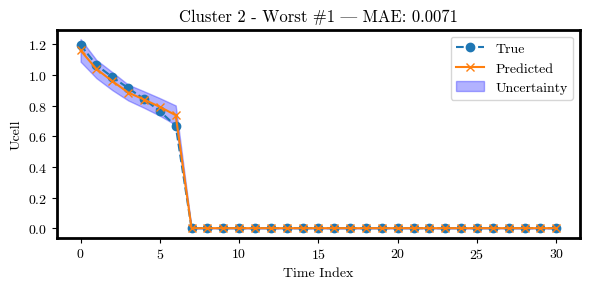

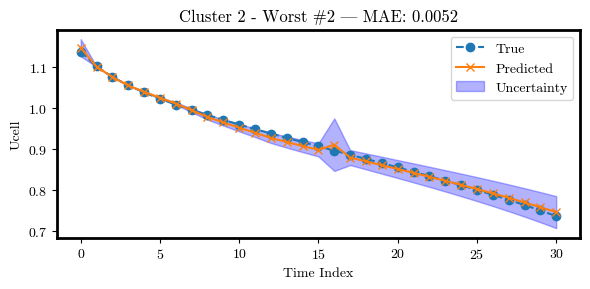

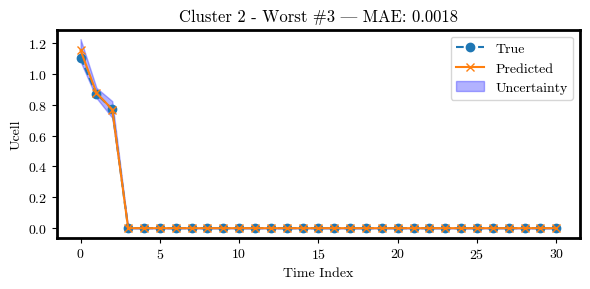

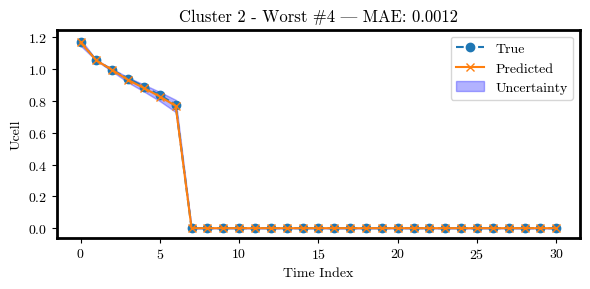

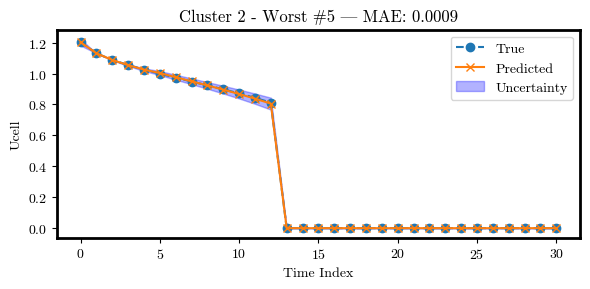

In [178]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_cluster_predictions(cluster_results, n_worst=5):
    for result in cluster_results:
        cluster_id = result["cluster_id"]
        Y_test = result["Y_test"]
        Y_pred = result["Y_pred"]
        Y_std = result["Y_std"]
        mae = result["mae_per_curve"]

        worst_indices = np.argsort(mae)[-n_worst:]

        for i, idx in enumerate(worst_indices[::-1]):
            plt.figure(figsize=(6, 3))
            time = np.arange(Y_test.shape[1])
            plt.plot(time, Y_test[idx], label="True", linestyle='--', marker='o')
            plt.plot(time, Y_pred[idx], label="Predicted", marker='x')
            plt.fill_between(time,
                             Y_pred[idx] - Y_std[idx],
                             Y_pred[idx] + Y_std[idx],
                             alpha=0.3, color='blue', label='Uncertainty')

            plt.title(f'Cluster {cluster_id} - Worst #{i+1} | MAE: {mae[idx]:.4f}')
            plt.xlabel('Time Index')
            plt.ylabel('Ucell')
            plt.legend()
            plt.tight_layout()
            plt.show()

visualize_cluster_predictions(cluster_results, n_worst=5)


In [179]:
from sklearn.metrics import r2_score
import numpy as np

# Concatenate all test and predicted outputs across clusters
Y_test_all = np.vstack([cluster['Y_test'] for cluster in cluster_results])
Y_pred_all = np.vstack([cluster['Y_pred'] for cluster in cluster_results])

# Compute global R² score
r2_global = r2_score(Y_test_all, Y_pred_all, multioutput='uniform_average')

print(f"Global R² score across all clusters: {r2_global:.3f}")


Global R² score across all clusters: 0.994


Accuracy: 0.9426
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       107
           1       0.71      0.71      0.71         7
           2       1.00      0.62      0.77         8

    accuracy                           0.94       122
   macro avg       0.89      0.77      0.82       122
weighted avg       0.94      0.94      0.94       122



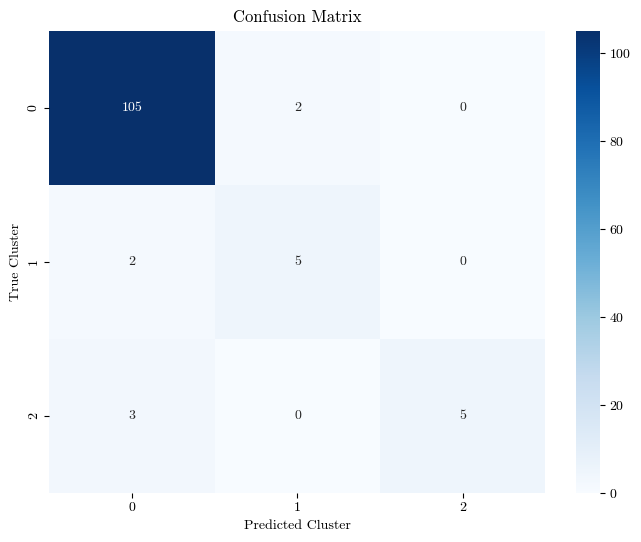

In [234]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

scaler = StandardScaler()
curves_normalized = scaler.fit_transform(stretched_Y)  # normalize each curve (row-wise)

# === Step 2: Reduce dimensionality with PCA ===
# This helps with clustering by capturing the main variance directions
pca = PCA(n_components=10)
curve_features = pca.fit_transform(curves_normalized)

# === Step 3: Cluster the curves ===
k = 3  # You can set this to any number of clusters you want
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(curve_features)

# 2. Split data (X and cluster labels) into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=labels)

# 3. Train classifier to predict cluster labels from X
cluster_clf = RandomForestClassifier(random_state=42)
cluster_clf.fit(X_train, y_train)

# 4. Predict on test data
y_pred = cluster_clf.predict(X_test)

# 5. Evaluate classifier
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.title('Confusion Matrix')
plt.show()


In [236]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.multioutput import MultiOutputRegressor

X = np.array(data[PARAMETER_RANGES.keys()])
Y = np.array(data['Ucell'].tolist())

# Filter invalid outputs
#mask_valid = np.all((Y > 0) & (Y < 1.5), axis=1)
X = X[mask_valid]
Y = Y[mask_valid]

# 1. Split data into train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# 2. Scale + PCA on train data and transform test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. Cluster train data (in PCA space)
k = 3  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
train_cluster_labels = kmeans.fit_predict(X_train_pca)

# 4. Train classifier to predict clusters (in PCA space)
cluster_clf = RandomForestClassifier(random_state=42)
cluster_clf.fit(X_train_pca, train_cluster_labels)

# 5. Predict clusters for test data
test_cluster_labels = cluster_clf.predict(X_test_pca)

# 6. For each cluster, train a GP on train data and predict test data in that cluster
cluster_results = []

for cluster_id in range(k):
    # Select train data in this cluster (PCA space)
    X_train_cluster = X_train_pca[train_cluster_labels == cluster_id]
    Y_train_cluster = Y_train[train_cluster_labels == cluster_id]

    # Select test data in this cluster
    X_test_cluster = X_test_pca[test_cluster_labels == cluster_id]
    Y_test_cluster = Y_test[test_cluster_labels == cluster_id]

    if len(X_test_cluster) == 0:
        continue  # skip empty clusters in test

    # Train GP on train cluster
    kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5)
    multi_gp = MultiOutputRegressor(gp)
    multi_gp.fit(X_train_cluster, Y_train_cluster)

    # Predict on test cluster
    Y_pred = []
    Y_std = []
    for estimator in multi_gp.estimators_:
        mu, std = estimator.predict(X_test_cluster, return_std=True)
        Y_pred.append(mu)
        Y_std.append(std)

    Y_pred = np.array(Y_pred).T
    Y_std = np.array(Y_std).T
    mae = np.mean(np.abs(Y_pred - Y_test_cluster))
    # Store results
    cluster_results.append({
        "cluster_id": cluster_id,
        "gp_model": multi_gp,
        "X_test_cluster": X_test_cluster,
        "Y_test_cluster": Y_test_cluster,
        "Y_pred": Y_pred,
        "Y_std": Y_std,
        "mae": mae
    })

# Example: print MAE for each cluster
for res in cluster_results:
    mae = np.mean(np.abs(res["Y_pred"] - res["Y_test_cluster"]))
    print(f"Cluster {res['cluster_id']} MAE: {mae:.4f}")




c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of p

Cluster 0 MAE: 175.3153
Cluster 1 MAE: 0.5569
Cluster 2 MAE: 4813.6776


c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of p

In [241]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

# Prepare data
X = np.array(data[PARAMETER_RANGES.keys()])
Y = np.array(data['Ucell'].tolist())

# Optional: filter valid outputs
# mask_valid = np.all((Y > 0) & (Y < 1.5), axis=1)
# X, Y = X[mask_valid], Y[mask_valid]

# 1. Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# 2. Scale + PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. Clustering on train set
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
train_cluster_labels = kmeans.fit_predict(X_train_pca)

# 4. Train GPs per cluster
cluster_models = {}
for cluster_id in range(k):
    X_cluster = X_train_pca[train_cluster_labels == cluster_id]
    Y_cluster = Y_train[train_cluster_labels == cluster_id]

    kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
    base_gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5)
    gp_model = MultiOutputRegressor(base_gp)
    gp_model.fit(X_cluster, Y_cluster)

    cluster_models[cluster_id] = gp_model

# 5. Predict test samples with all GPs and choose best prediction
best_preds = []
best_clusters = []

for i in range(X_test_pca.shape[0]):
    x = X_test_pca[i].reshape(1, -1)
    y_true = Y_test[i]

    best_mae = np.inf
    best_pred = None
    best_cluster = None

    for cluster_id, gp_model in cluster_models.items():
        y_pred = np.column_stack([
            estimator.predict(x) for estimator in gp_model.estimators_
        ])[0]

        mae = np.mean(np.abs(y_pred - y_true))

        if mae < best_mae:
            best_mae = mae
            best_pred = y_pred
            best_cluster = cluster_id

    best_preds.append(best_pred)
    best_clusters.append(best_cluster)

best_preds = np.array(best_preds)
overall_mae = mean_absolute_error(Y_test, best_preds)

print(f"\nOverall MAE (best cluster per test sample): {overall_mae:.4f}")


c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal va


Overall MAE (best cluster per test sample): 428.4190


In [242]:
from sklearn.metrics import r2_score
import numpy as np

# Concatenate all test and predicted outputs across clusters
Y_test_all = np.vstack([cluster['Y_test_cluster'] for cluster in cluster_results])
Y_pred_all = np.vstack([cluster['Y_pred'] for cluster in cluster_results])

# Compute global R² score (averaged over outputs)
r2_global = r2_score(Y_test_all, Y_pred_all, multioutput='uniform_average')

print(f"Global R² score across all clusters: {r2_global:.3f}")


Global R² score across all clusters: -357.093


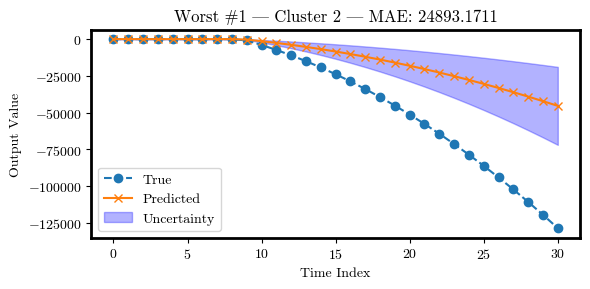

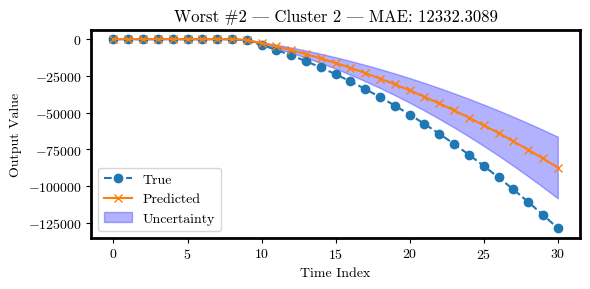

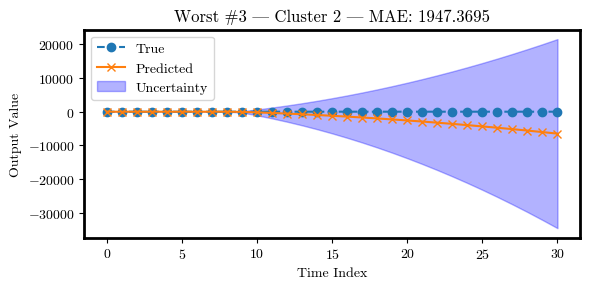

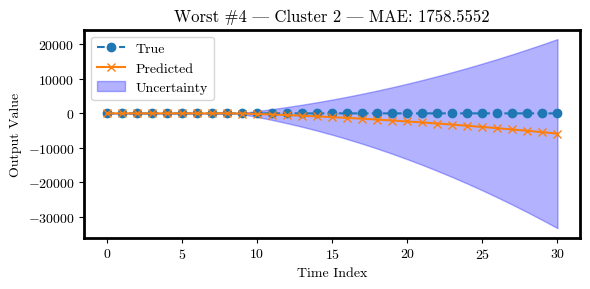

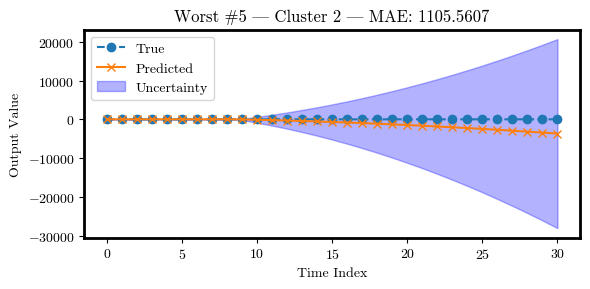

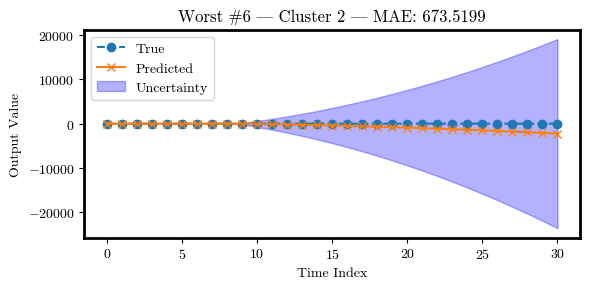

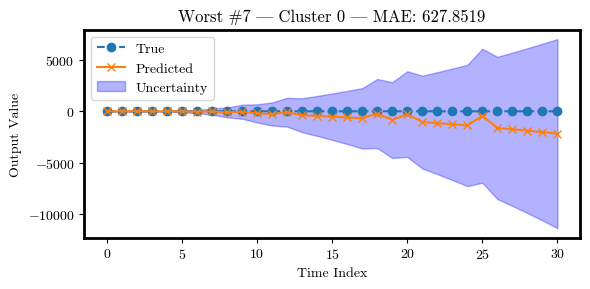

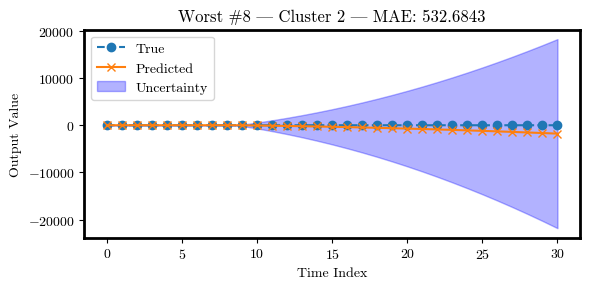

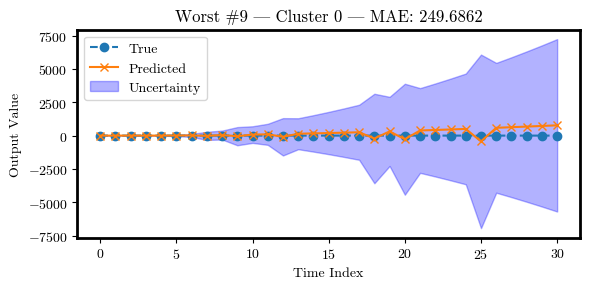

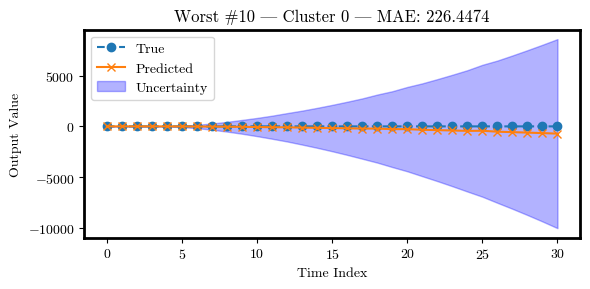

In [246]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_overall_worst_predictions(cluster_results, n_worst=5):
    all_entries = []

    for result in cluster_results:
        cluster_id = result["cluster_id"]
        Y_test = result["Y_test_cluster"]
        Y_pred = result["Y_pred"]
        Y_std = result["Y_std"]

        # Compute MAE per test sample
        sample_maes = np.mean(np.abs(Y_test - Y_pred), axis=1)

        for i in range(len(sample_maes)):
            all_entries.append({
                "cluster_id": cluster_id,
                "index": i,
                "mae": sample_maes[i],
                "y_true": Y_test[i],
                "y_pred": Y_pred[i],
                "y_std": Y_std[i],
            })

    # Sort all samples by MAE
    all_entries_sorted = sorted(all_entries, key=lambda x: x["mae"], reverse=True)
    worst_entries = all_entries_sorted[:n_worst]

    # Plot
    for rank, entry in enumerate(worst_entries, 1):
        time = np.arange(len(entry["y_true"]))
        plt.figure(figsize=(6, 3))
        plt.plot(time, entry["y_true"], label="True", linestyle='--', marker='o')
        plt.plot(time, entry["y_pred"], label="Predicted", marker='x')
        plt.fill_between(time,
                         entry["y_pred"] - entry["y_std"],
                         entry["y_pred"] + entry["y_std"],
                         color='blue', alpha=0.3, label='Uncertainty')

        plt.title(f'Worst #{rank} | Cluster {entry["cluster_id"]} | MAE: {entry["mae"]:.4f}')
        plt.xlabel('Time Index')
        plt.ylabel('Output Value')
        plt.legend()
        plt.tight_layout()
        plt.show()

visualize_overall_worst_predictions(cluster_results, n_worst=10)
